# **Import modules**

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import random

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Download Datasets**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Emotion_Recognition/

/content/drive/MyDrive/Emotion_Recognition


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

## 1- RAVDESS

Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02) Speech (01) Fearful (06) Normal intensity (01) Statement "dogs" (02) 1st Repetition (01) 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
!mkdir RAVDESS

In [4]:
%cd /content/drive/MyDrive/Emotion_Recognition/RAVDESS/

/content/drive/MyDrive/Emotion_Recognition/RAVDESS


In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

In [ ]:
!unzip /content/drive/MyDrive/Emotion_Recognition/RAVDESS/ravdess-emotional-speech-audio.zip

In [6]:
RAVDESS_path = "/content/drive/MyDrive/Emotion_Recognition/RAVDESS/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(RAVDESS_path)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(RAVDESS_path + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(RAVDESS_path + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
print(len(Ravdess_df))
Ravdess_df.head()


1440


,Emotions,Path
0,happy,/content/drive/MyDrive/Emotion_Recognition/RAV...
1,angry,/content/drive/MyDrive/Emotion_Recognition/RAV...
2,calm,/content/drive/MyDrive/Emotion_Recognition/RAV...
3,fear,/content/drive/MyDrive/Emotion_Recognition/RAV...
4,sad,/content/drive/MyDrive/Emotion_Recognition/RAV...


## 2- CREMA

In [ ]:
%cd /content/drive/MyDrive/Emotion_Recognition/

In [ ]:
!mkdir CREMA

In [ ]:
%cd /content/drive/MyDrive/Emotion_Recognition/CREMA/

In [ ]:
!kaggle datasets download -d ejlok1/cremad

In [ ]:
!unzip /content/drive/MyDrive/Emotion_Recognition/CREMA/cremad.zip

In [7]:
CREMA_path = "/content/drive/MyDrive/Emotion_Recognition/CREMA/AudioWAV/"
crema_directory_list = os.listdir(CREMA_path)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(CREMA_path + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
print(len(Crema_df))
Crema_df.head()


7442


,Emotions,Path
0,disgust,/content/drive/MyDrive/Emotion_Recognition/CRE...
1,happy,/content/drive/MyDrive/Emotion_Recognition/CRE...
2,fear,/content/drive/MyDrive/Emotion_Recognition/CRE...
3,sad,/content/drive/MyDrive/Emotion_Recognition/CRE...
4,sad,/content/drive/MyDrive/Emotion_Recognition/CRE...


## 3- TESS

In [ ]:
%cd /content/drive/MyDrive/Emotion_Recognition/

In [ ]:
!mkdir TESS

In [ ]:
%cd /content/drive/MyDrive/Emotion_Recognition/TESS/

In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

In [ ]:
!unzip /content/drive/MyDrive/Emotion_Recognition/TESS/toronto-emotional-speech-set-tess.zip

In [8]:
TESS_path = "/content/drive/MyDrive/Emotion_Recognition/TESS/TESS_Toronto_emotional_speech_set_data/"
tess_directory_list = os.listdir(TESS_path)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(TESS_path + dir)
    for file_ in directories:
        part = file_.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(TESS_path + dir + '/' + file_)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
print(len(Tess_df))
Tess_df.head()

2800


,Emotions,Path
0,fear,/content/drive/MyDrive/Emotion_Recognition/TES...
1,fear,/content/drive/MyDrive/Emotion_Recognition/TES...
2,fear,/content/drive/MyDrive/Emotion_Recognition/TES...
3,fear,/content/drive/MyDrive/Emotion_Recognition/TES...
4,fear,/content/drive/MyDrive/Emotion_Recognition/TES...


## 4- SAVEE

In [ ]:
%cd /content/drive/MyDrive/Emotion_Recognition/

In [ ]:
!mkdir SAVEE

In [ ]:
%cd /content/drive/MyDrive/Emotion_Recognition/SAVEE/

In [ ]:
!kaggle datasets download -d barelydedicated/savee-database

In [ ]:
!unzip /content/drive/MyDrive/Emotion_Recognition/SAVEE/savee-database.zip

In [9]:
SAVEE_path = "/content/drive/MyDrive/Emotion_Recognition/SAVEE/AudioData/"
savee_directory_list = os.listdir(SAVEE_path)
savee_directory_list.remove("Info.txt")

file_emotion = []
file_path = []

for folder in savee_directory_list:
  path = SAVEE_path + folder + '/'
  for file_ in os.listdir(path):

    file_path.append(SAVEE_path + folder + '/' + file_)
    part = file_.split('.')[0]
    ele = part[:-2]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
print(len(Savee_df))
Savee_df.head()


480


,Emotions,Path
0,angry,/content/drive/MyDrive/Emotion_Recognition/SAV...
1,angry,/content/drive/MyDrive/Emotion_Recognition/SAV...
2,angry,/content/drive/MyDrive/Emotion_Recognition/SAV...
3,angry,/content/drive/MyDrive/Emotion_Recognition/SAV...
4,angry,/content/drive/MyDrive/Emotion_Recognition/SAV...


# **Merge all datasets together**

In [13]:
# merge all data frames together 
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)

# save the data frame and make index=False because we will have 4 records for each index
data_path.to_csv("data_path.csv",index=False)
print(len(data_path))
data_path.head()

12162


,Emotions,Path
0,happy,/content/drive/MyDrive/Emotion_Recognition/RAV...
1,angry,/content/drive/MyDrive/Emotion_Recognition/RAV...
2,calm,/content/drive/MyDrive/Emotion_Recognition/RAV...
3,fear,/content/drive/MyDrive/Emotion_Recognition/RAV...
4,sad,/content/drive/MyDrive/Emotion_Recognition/RAV...


In [15]:
# read data frame and make sure that each index has one record not 4
data_path = pd.read_csv('data_path.csv')
print(data_path.Path[0])

/content/drive/MyDrive/Emotion_Recognition/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-03-01-01-01-01.wav


# **Exploratory Data Analysis**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


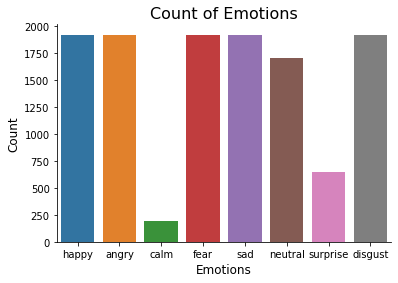

In [16]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [17]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

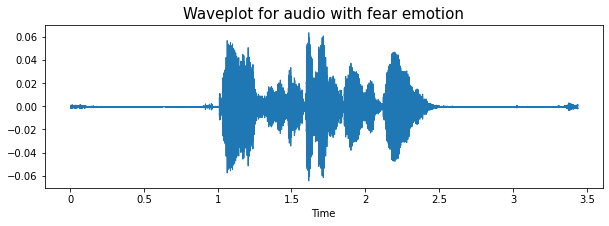

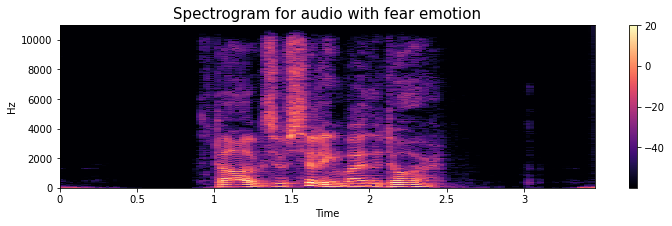

In [18]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

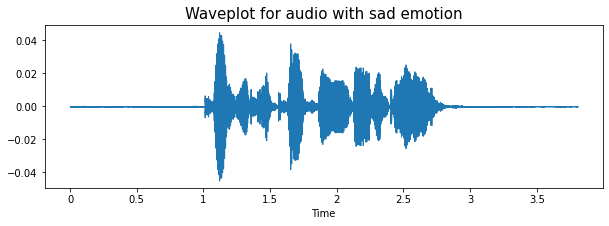

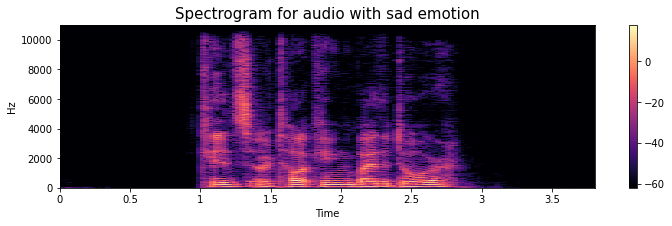

In [19]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# **Data Augmentation**

In [20]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal


def time_stretch(signal, time_stretch_rate):
  
    return librosa.effects.time_stretch(signal, time_stretch_rate)


def pitch_scale(signal, sr, num_semitones):
    
    return librosa.effects.pitch_shift(signal, sr, num_semitones)


def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal


def invert_polarity(signal):
    return signal * -1

In [21]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
  fig, ax = plt.subplots(nrows=2)
  librosa.display.waveshow(signal, sr=sr, ax=ax[0])
  ax[0].set(title='Original Signal')
  librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
  ax[1].set(title='Augmented Signal')
  plt.show()

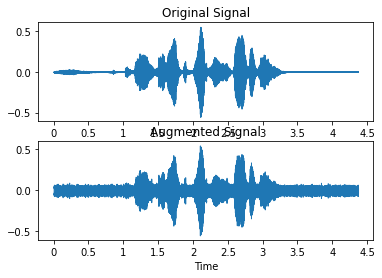

In [23]:
path = np.array(data_path.Path)[1]
data, sr = librosa.load(path)
augmented_signal = add_white_noise(data, 0.4)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

# **Feature Extraction**

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = add_white_noise(data, 0.4)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching
    stretch_data = time_stretch(data, 0.8)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching
    pitch_data = pitch_scale(data, sr, 0.7)
    res4 = extract_features(pitch_data)
    result = np.vstack((result, res4)) # stacking vertically

    # data with polarity inversion
    ivert_data = invert_polarity(data)
    res5 = extract_features(ivert_data)
    result = np.vstack((result, res5)) # stacking vertically
    
    return result


In [ ]:
X, Y = [], []

for path, emotion in zip(data_path.Path, data_path.Emotions):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        # appending emotion 5 times as we have made 5 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
print(len(Features))
Features.head()

# **Data Preparation**

In [ ]:
Features = pd.read_csv('features.csv')

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45607, 162), (45607, 8), (15203, 162), (15203, 8))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45607, 162), (45607, 8), (15203, 162), (15203, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45607, 162, 1), (45607, 8), (15203, 162, 1), (15203, 8))

# **Model**

In [ ]:
model = Sequential()

model.add((LSTM(128, input_shape=(x_train.shape[1], 1), return_sequences=True)))
model.add((LSTM(128, return_sequences=True)))
model.add(Dropout(0.25))

model.add((LSTM(64, return_sequences=True)))
model.add((LSTM(32, return_sequences=True)))
model.add((LSTM(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add((LSTM(128, return_sequences=True)))
model.add((LSTM(128)))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 162, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 162, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 162, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 162, 64)           49408     
                                                                 
 lstm_3 (LSTM)               (None, 162, 32)           12416     
                                                                 
 lstm_4 (LSTM)               (None, 162, 64)           24832     
                                                                 
 batch_normalization (BatchN  (None, 162, 64)          2

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
713/713 [==============================] - 73s 80ms/step - loss: 1.8508 - accuracy: 0.2518 - val_loss: 1.8036 - val_accuracy: 0.2691 - lr: 0.0010
Epoch 2/100
713/713 [==============================] - 48s 68ms/step - loss: 1.8712 - accuracy: 0.2344 - val_loss: 2.1029 - val_accuracy: 0.1663 - lr: 0.0010
Epoch 3/100
713/713 [==============================] - 47s 66ms/step - loss: 1.7305 - accuracy: 0.3081 - val_loss: 1.7352 - val_accuracy: 0.3059 - lr: 0.0010
Epoch 4/100
713/713 [==============================] - 46s 65ms/step - loss: 1.6560 - accuracy: 0.3392 - val_loss: 1.5851 - val_accuracy: 0.3705 - lr: 0.0010
Epoch 5/100
713/713 [==============================] - 47s 66ms/step - loss: 1.5976 - accuracy: 0.3629 - val_loss: 1.5267 - val_accuracy: 0.3885 - lr: 0.0010
Epoch 6/100
713/713 [==============================] - 48s 67ms/step - loss: 1.5536 - accuracy: 0.3795 - val_loss: 1.6597 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 7/100
713/713 [==============================]

476/476 [==============================] - 11s 22ms/step - loss: 1.4500 - accuracy: 0.7396
Accuracy of our model on test data :  73.95908832550049 %


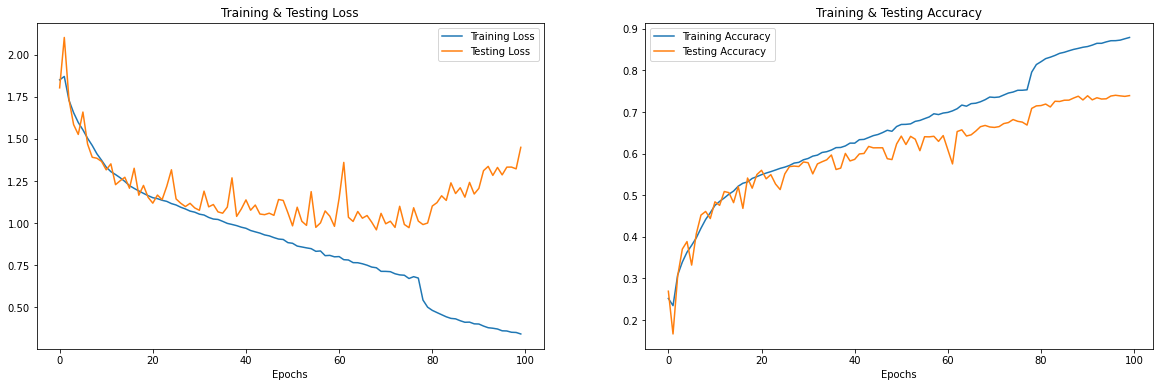

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [ ]:
# predicting on test data.

pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,happy
1,neutral,sad
2,disgust,disgust
3,fear,fear
4,sad,sad
5,neutral,neutral
6,surprise,surprise
7,happy,sad
8,happy,happy
9,fear,fear


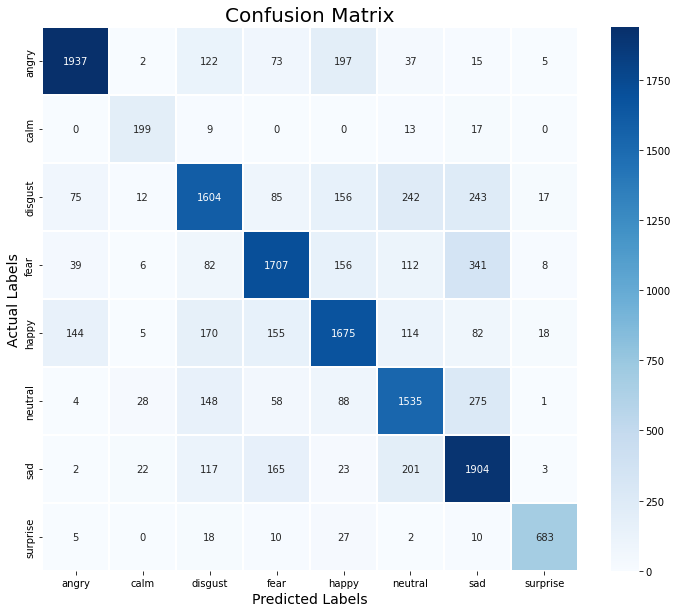

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
model.save('Emotion_Recognition_weights.h5')